## import & load

In [2]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

from collections import defaultdict
import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [3]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

In [4]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [5]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.cache)
importlib.reload(market_data.ingest.bq.candle)

<module 'market_data.ingest.bq.candle' from '/home/junlim/projects/jitter_recovery/market_data/ingest/bq/candle.py'>

In [29]:
date_str_from='2023-12-01'
date_str_to='2024-01-01'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode, 
    export_mode, 
    market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, date_str_to=date_str_to)
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [27]:
all_symbols = df.symbol.unique()
all_symbols = [s for s in all_symbols if s]
len([s for s in all_symbols if 'USDT' in s])

164

## calculate/cache features

In [6]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.collective_jitter_recovery.calculate
importlib.reload(algo.collective_jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)
import algo.collective_jitter_recovery.research
importlib.reload(algo.collective_jitter_recovery.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/home/junlim/projects/jitter_recovery/algo/cache.py'>

In [7]:
feature_param = algo.collective_jitter_recovery.calculate.CollectiveJitterFeatureParam(window=40, collective_window=30)

In [9]:
algo.collective_jitter_recovery.research.get_feature_label_for_caching(feature_param)

'(collectivechanges)_window(40)_collective_window(30)'

In [8]:
import market_data.ingest.bq.common
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [31]:
dfst_feature = algo.cache.read_df(
    label = algo.collective_jitter_recovery.research.get_feature_label_for_caching(feature_param),
    dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    date_str_from='2023-12-01', 
    date_str_to='2024-01-01')

## multiple symbols

In [13]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.collective_jitter_recovery.calculate
importlib.reload(algo.collective_jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)
import algo.collective_jitter_recovery.research
importlib.reload(algo.collective_jitter_recovery.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/home/junlim/projects/jitter_recovery/algo/cache.py'>

In [10]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.collective_jitter_recovery.calculate
importlib.reload(algo.collective_jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)
import algo.collective_jitter_recovery.research
importlib.reload(algo.collective_jitter_recovery.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/home/junlim/projects/jitter_recovery/algo/cache.py'>

In [67]:
df_collective_feature = dfst_feature.dropna().groupby('timestamp')[
    collective_feature_columns_no_rolling].median().resample('1min').asfreq().ffill()
df_collective_feature['ch_std'] = dfst_feature.dropna().groupby('timestamp')[
        ['ch']].std().resample('1min').asfreq().ffill().values
df_collective_feature['ch_window30_min'] = df_collective_feature.ch.rolling(window=30).min()
df_collective_feature['ch_window30_max'] = df_collective_feature.ch.rolling(window=30).max()

In [75]:
df_collective_feature = algo.collective_jitter_recovery.research.get_df_collective_feature(dfst_feature)

In [76]:
df_collective_feature.columns

Index(['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min', 'ch_std',
       'ch_window30_min', 'ch_window30_max'],
      dtype='object')

<Axes: xlabel='timestamp'>

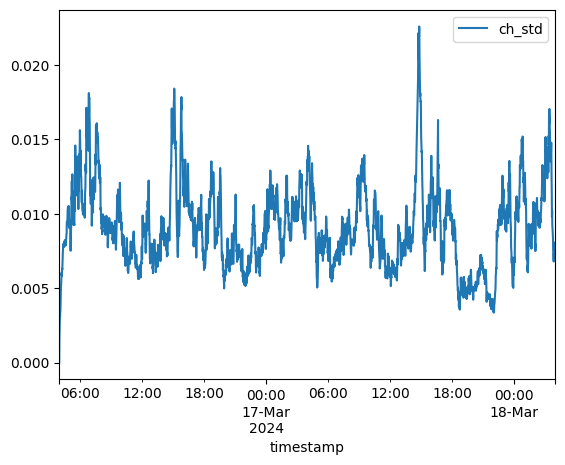

In [82]:
df_collective_feature[['ch_std']].plot()

In [79]:
dfst_with_collective_feature = algo.collective_jitter_recovery.research.append_collective_feature(df, dfst_feature)

In [80]:
dfst_with_collective_feature.columns

Index(['open', 'high', 'low', 'close', 'volume', 'avg_v_before_max_ch',
       'avg_v_before_min_ch', 'ch', 'ch_max', 'ch_min', 'ch_since_max',
       'ch_since_min', 'distance_max_ch', 'distance_min_ch',
       'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from',
       'v_ch_min_is_to', 'value', 'ch_collective', 'ch_max_collective',
       'ch_min_collective', 'ch_since_max_collective',
       'ch_since_min_collective', 'ch_std_collective',
       'ch_window30_min_collective', 'ch_window30_max_collective'],
      dtype='object')

In [85]:
dfst_with_collective_feature[
    (dfst_with_collective_feature.ch - dfst_with_collective_feature.ch_collective) > 0.10
].index.get_level_values('symbol').unique()

Index(['RAY-USDT-SWAP', 'YGG-USDT-SWAP', 'JOE-USDT-SWAP', 'ZRX-USDT-SWAP',
       'JUP-USDT-SWAP', 'SWEAT-USDT-SWAP', 'FRONT-USDT-SWAP',
       'DMAIL-USDT-SWAP', 'GPT-USDT-SWAP', 'LPT-USDT-SWAP', 'OM-USDT-SWAP',
       'FLR-USDT-SWAP', 'BONE-USDT-SWAP', 'MASK-USDT-SWAP'],
      dtype='object', name='symbol')

In [ ]:
dfst_with_collective_feature[
    (dfst_with_collective_feature.)
]

In [35]:
collective_feature_columns_no_rolling = ['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min']
df_collective_feature = dfst_feature.dropna().groupby('timestamp')[collective_feature_columns_no_rolling].median().resample('1min').asfreq().ffill()
df_collective_feature['ch_window30_min'] = df_collective_feature.ch.rolling(window=30).min() 
df_collective_feature['ch_window30_max'] = df_collective_feature.ch.rolling(window=30).max() 
df_collective_feature['ch_window60_min'] = df_collective_feature.ch.rolling(window=60).min() 
df_collective_feature['ch_window60_max'] = df_collective_feature.ch.rolling(window=60).max() 

<Axes: xlabel='timestamp'>

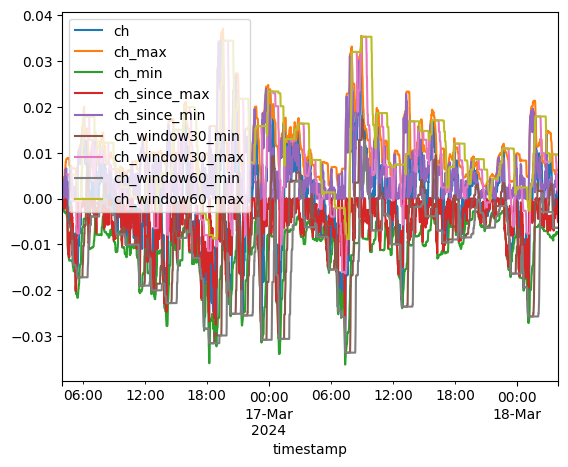

In [36]:
df_collective_feature.plot()

array([[<Axes: title={'center': 'profit'}>]], dtype=object)

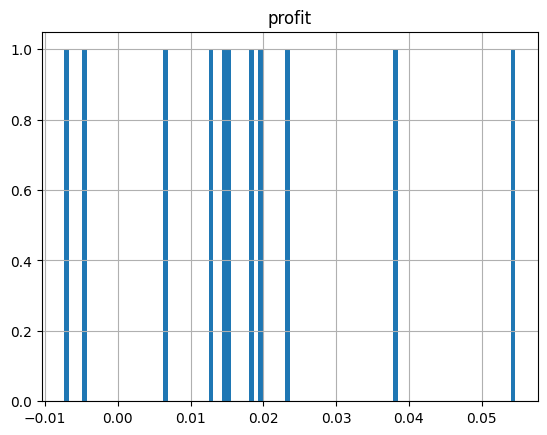

In [105]:
dfst_trading[dfst_trading.profit != 0][['profit']].dropna().groupby('symbol').sum().sort_values('profit').hist(bins=100)

In [615]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if 'PERP' not in row['symbol']: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:13:00, PERP-USDT-SWAP, 1.6581, position_changed: 1.0
2024-01-03 12:16:00, PERP-USDT-SWAP, 1.8838, position_changed: -1.0
2024-01-03 12:17:00, PERP-USDT-SWAP, 1.8575, position_changed: 1.0
2024-01-03 12:18:00, PERP-USDT-SWAP, 1.8033, position_changed: -1.0
2024-01-03 12:19:00, PERP-USDT-SWAP, 1.6796, position_changed: 1.0
2024-01-03 12:23:00, PERP-USDT-SWAP, 1.81, position_changed: -1.0
2024-01-03 12:24:00, PERP-USDT-SWAP, 1.8786, position_changed: 1.0
2024-01-03 12:25:00, PERP-USDT-SWAP, 1.801, position_changed: -1.0
2024-01-03 12:26:00, PERP-USDT-SWAP, 1.8229, position_changed: 1.0
2024-01-03 12:27:00, PERP-USDT-SWAP, 1.7579, position_changed: -1.0
2024-01-03 12:28:00, PERP-USDT-SWAP, 1.81, position_changed: 1.0
2024-01-03 12:29:00, PERP-USDT-SWAP, 1.8183, position_changed: -1.0
